<a href="https://colab.research.google.com/github/8sheeta8/Attack_Network_AI/blob/main/XSS/XSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 및 정규화
latent_dim = 128  # 증가된 latent dimension
data = np.load("/content/drive/MyDrive/sooin/payload/xss_payload.npy")
data = (data.astype(np.float32) / 127.5) - 1.0  # [-1, 1]로 정규화
data = torch.tensor(data, dtype=torch.float32)

# 데이터에 약간의 노이즈 추가하여 다양성 확보
data += 0.01 * torch.randn_like(data)

batch_size = 64
epochs = 1000  # 증가된 epoch 수

dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
# Generator (수정)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, data.shape[1]),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

# Critic
# Critic (수정)
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data.shape[1], 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.model(x)

# Gradient Penalty
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand(real_samples.size())

    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

# 모델 초기화
G = Generator().to(device)
D = Critic().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# 학습
lambda_gp = 10  # 기존보다 증가
n_critic = 3
g_losses, d_losses = [], []

for epoch in range(epochs):
    noise_scale = 1.0 + (epoch / epochs) * 0.5  # latent noise scale 1.0 -> 1.5
    for i, (real_batch,) in enumerate(loader):
        real_batch = real_batch.to(device)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), latent_dim).to(device) * noise_scale
            fake_data = G(z).detach()
            real_validity = D(real_batch)
            fake_validity = D(fake_data)
            gradient_penalty = compute_gradient_penalty(D, real_batch.data, fake_data.data)

            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Train Generator
        z = torch.randn(real_batch.size(0), latent_dim).to(device) * noise_scale
        gen_data = G(z)
        g_loss = -torch.mean(D(gen_data))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    if (epoch + 1) % 100 == 0:
      print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} | G: {g_loss.item():.4f}")

In [ ]:
# 학습 종료 후 벡터 수집
G.eval()
with torch.no_grad():
    # 일부 실제 데이터
    real_vectors = data[:1000].to(device)  # 예시: 처음 1000개
    # 일부 가짜 데이터 생성
    z = torch.randn(1000, latent_dim).to(device)
    fake_vectors = G(z)

# 모델 저장 경로
checkpoint_path = "/content/drive/MyDrive/model/wgan_xss.pth"

# 모델 및 학습 정보 저장
torch.save({
    'generator_state_dict': G.state_dict(),
    'critic_state_dict': D.state_dict(),
    'loss_g': g_losses,
    'loss_d': d_losses,
    'real_vectors': real_vectors.cpu(),
    'fake_vectors': fake_vectors.cpu()
}, checkpoint_path)

print("모델과 학습 정보를 성공적으로 저장했습니다.")

In [ ]:
# -------------------------------
# 학습 결과 시각화
# -------------------------------
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN-GP Loss')
plt.show()

# ─────────────────────────────────────
# ✅ C2ST 평가
# ─────────────────────────────────────
# 평가 시 샘플 수 증가

real_samples = data[:300].numpy()
with torch.no_grad():
    z = torch.randn(300, latent_dim).to(device) * 1.5
    fake_samples = G(z).cpu().numpy()

X = np.vstack([real_samples, fake_samples])  # 600 samples
y = np.array([0]*300 + [1]*300)              # labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n🔍 [C2ST Accuracy] Real vs Generated 분류 정확도: {acc*100:.2f}%")

# ─────────────────────────────────────
# ✅ 코사인 유사도 측정 (정량적 평가)
# ─────────────────────────────────────
cosine_similarities = []
for real_vec, fake_vec in zip(real_samples, fake_samples):
    similarity = 1 - cosine(real_vec, fake_vec)
    cosine_similarities.append(similarity)

avg_cosine_similarity = np.mean(cosine_similarities)
print(f"[Cosine Similarity] 평균 코사인 유사도 (Real vs Generated): {avg_cosine_similarity:.4f}")

# ─────────────────────────────────────
# ✅ t-SNE 시각화
# ─────────────────────────────────────
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(embedded[:300,0], embedded[:300,1], label="Real", alpha=0.6)
plt.scatter(embedded[300:,0], embedded[300:,1], label="Generated", alpha=0.6)
plt.title("t-SNE Visualization of Payloads (Improved WGAN-GP)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 저장된 체크포인트 로드
checkpoint_path = "/content/drive/MyDrive/model/wgan_xss.pth"
checkpoint = torch.load(checkpoint_path)

# 손실 값 불러오기
g_losses = checkpoint['loss_g']
d_losses = checkpoint['loss_d']

# 실제 및 가짜 벡터 불러오기
real_vectors = checkpoint['real_vectors']
fake_vectors = checkpoint['fake_vectors']

# 1. Generator / Critic Loss 시각화
plt.figure(figsize=(10, 4))
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.plot(d_losses, label="Critic Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# 벡터 결합
all_vectors = torch.cat([real_vectors, fake_vectors], dim=0).numpy()
labels = np.array([0]*len(real_vectors) + [1]*len(fake_vectors))  # 0: real, 1: fake

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_vectors)

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[labels==0, 0], tsne_result[labels==0, 1], label="Real", alpha=0.5)
plt.scatter(tsne_result[labels==1, 0], tsne_result[labels==1, 1], label="Fake", alpha=0.5)
plt.legend()
plt.title("t-SNE of Real and Fake Vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

# 평균 벡터 계산
real_mean = real_vectors.mean(dim=0, keepdim=True)
fake_mean = fake_vectors.mean(dim=0, keepdim=True)

# 코사인 유사도 계산
similarity = cosine_similarity(real_mean, fake_mean)
print(f"Real vs Fake 벡터의 평균 코사인 유사도: {similarity.item():.4f}")

# 2

[100/1000] D: -0.1423 | G: 2.2252
[200/1000] D: -0.2970 | G: 2.5905
[300/1000] D: -0.0393 | G: 2.7499
[400/1000] D: -0.1118 | G: 3.3336
[500/1000] D: -0.3338 | G: 3.6274
[600/1000] D: 0.0345 | G: 3.7975
[700/1000] D: -0.1192 | G: 3.9441
[800/1000] D: -0.0607 | G: 4.1554
[900/1000] D: -0.0789 | G: 4.0286
[1000/1000] D: -0.4017 | G: 4.1885


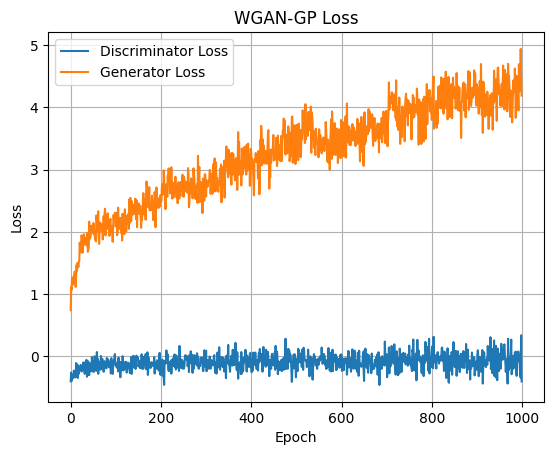

[Cosine Similarity] 평균 코사인 유사도: 0.9281


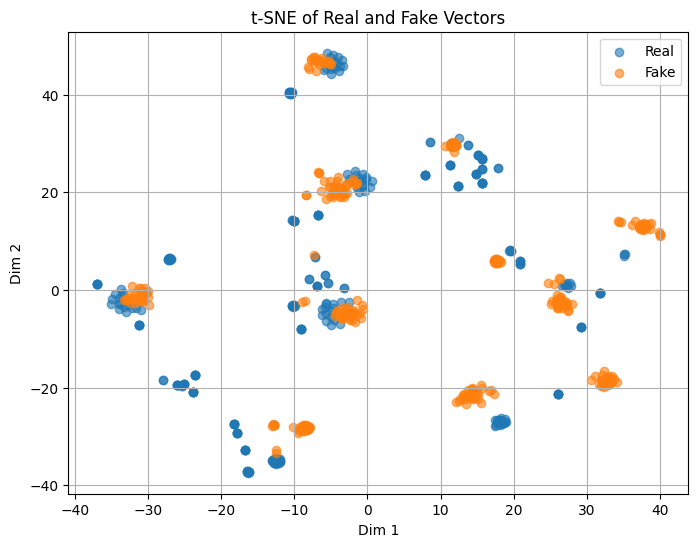

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# -------------------------------
# 설정
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
batch_size = 64
epochs = 1000
lambda_gp = 10
n_critic = 3

# -------------------------------
# 데이터 로드 및 정규화
# -------------------------------
data = np.load("/content/drive/MyDrive/sooin/payload/xss_payload.npy")
data = (data.astype(np.float32) / 127.5) - 1.0
data = torch.tensor(data, dtype=torch.float32)
data += 0.01 * torch.randn_like(data)

dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# Residual Block
# -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(x + self.block(x))

# -------------------------------
# Generator
# -------------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            ResidualBlock(512),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, data.shape[1]),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# -------------------------------
# Critic
# -------------------------------
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data.shape[1], 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# -------------------------------
# Gradient Penalty
# -------------------------------
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand(real_samples.size())
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# -------------------------------
# 모델 초기화
# -------------------------------
G = Generator().to(device)
D = Critic().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# -------------------------------
# 학습
# -------------------------------
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i, (real_batch,) in enumerate(loader):
        real_batch = real_batch.to(device)

        # Critic 학습
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            z *= torch.empty_like(z).uniform_(0.8, 1.2)  # 랜덤 스케일링
            fake_data = G(z).detach()
            real_validity = D(real_batch)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_batch.data, fake_data.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Generator 학습
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        z *= torch.empty_like(z).uniform_(0.8, 1.2)
        gen_data = G(z)
        g_loss = -torch.mean(D(gen_data))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} | G: {g_loss.item():.4f}")

# -------------------------------
# 손실 그래프
# -------------------------------
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN-GP Loss')
plt.grid(True)
plt.show()

# -------------------------------
# 생성 샘플 추출
# -------------------------------
with torch.no_grad():
    real_samples = data[:300].cpu().numpy()
    z = torch.randn(300, latent_dim).to(device)
    z *= torch.empty_like(z).uniform_(0.8, 1.2)
    fake_samples = G(z).cpu().numpy()

X = np.concatenate([real_samples, fake_samples], axis=0)

# -------------------------------
# 코사인 유사도
# -------------------------------
cosine_similarities = [
    1 - cosine(r, f) for r, f in zip(real_samples, fake_samples)
]
print(f"[Cosine Similarity] 평균 코사인 유사도: {np.mean(cosine_similarities):.4f}")

# -------------------------------
# t-SNE 시각화
# -------------------------------
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
embedded = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(embedded[:300, 0], embedded[:300, 1], label="Real", alpha=0.6)
plt.scatter(embedded[300:, 0], embedded[300:, 1], label="Fake", alpha=0.6)
plt.title("t-SNE of Real and Fake Vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# -------------------------------
# C2ST (Classifier Two-Sample Test)
# -------------------------------

# 1. 라벨링
X_real = real_samples
X_fake = fake_samples
X_c2st = np.concatenate([X_real, X_fake], axis=0)
y_c2st = np.array([0] * len(X_real) + [1] * len(X_fake))  # 0: real, 1: fake

# 2. 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_c2st, y_c2st, test_size=0.3, random_state=42)

# 3. 분류기 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 4. 정확도 측정
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"[C2ST] 구분 정확도: {accuracy * 100:.2f}%")


[C2ST] 구분 정확도: 100.00%


# 3

[100/1000] D: 0.0021 | G: 1.3928
[200/1000] D: -0.1288 | G: 2.4358
[300/1000] D: -0.1640 | G: 2.4279
[400/1000] D: 0.0111 | G: 3.4074
[500/1000] D: 0.1280 | G: 4.4156
[600/1000] D: 0.0270 | G: 4.3030
[700/1000] D: -0.2104 | G: 3.8005
[800/1000] D: 0.1645 | G: 4.0471
[900/1000] D: 0.0106 | G: 4.6379
[1000/1000] D: -0.0756 | G: 4.7966


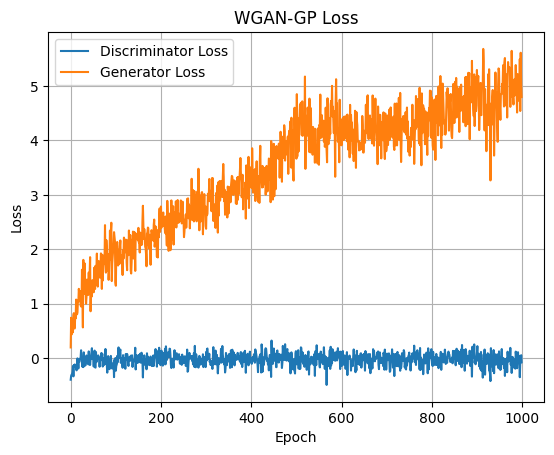

[Cosine Similarity] 평균 코사인 유사도: 0.9264


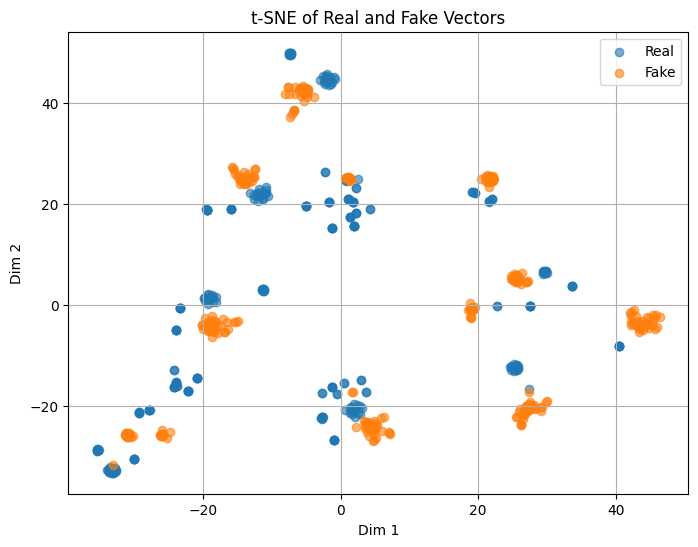

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# -------------------------------
# 설정
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
batch_size = 64
epochs = 1000
lambda_gp = 10
n_critic = 3

# -------------------------------
# 데이터 로드 및 정규화
# -------------------------------
data = np.load("/content/drive/MyDrive/sooin/payload/xss_payload.npy")
data = (data.astype(np.float32) / 127.5) - 1.0
data = torch.tensor(data, dtype=torch.float32)
data += 0.01 * torch.randn_like(data)

dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            Swish(),
            nn.Dropout(0.1),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )
        self.activation = Swish()

    def forward(self, x):
        return self.activation(x + self.block(x))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            Swish(),
            ResidualBlock(512),
            ResidualBlock(512),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            Swish(),
            nn.Linear(256, data.shape[1]),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# -------------------------------
# Critic
# -------------------------------
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data.shape[1], 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# -------------------------------
# Gradient Penalty
# -------------------------------
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand(real_samples.size())
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# -------------------------------
# 모델 초기화
# -------------------------------
G = Generator().to(device)
D = Critic().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# -------------------------------
# 학습
# -------------------------------
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i, (real_batch,) in enumerate(loader):
        real_batch = real_batch.to(device)

        # Critic 학습
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            z *= torch.empty_like(z).uniform_(0.8, 1.2)  # 랜덤 스케일링
            fake_data = G(z).detach()
            real_validity = D(real_batch)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_batch.data, fake_data.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Generator 학습
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        z *= torch.empty_like(z).uniform_(0.8, 1.2)
        gen_data = G(z)
        g_loss = -torch.mean(D(gen_data))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} | G: {g_loss.item():.4f}")

# -------------------------------
# 손실 그래프
# -------------------------------
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN-GP Loss')
plt.grid(True)
plt.show()

# -------------------------------
# 생성 샘플 추출
# -------------------------------
with torch.no_grad():
    real_samples = data[:300].cpu().numpy()
    z = torch.randn(300, latent_dim).to(device)
    z *= torch.empty_like(z).uniform_(0.8, 1.2)
    fake_samples = G(z).cpu().numpy()

X = np.concatenate([real_samples, fake_samples], axis=0)

# -------------------------------
# 코사인 유사도
# -------------------------------
cosine_similarities = [
    1 - cosine(r, f) for r, f in zip(real_samples, fake_samples)
]
print(f"[Cosine Similarity] 평균 코사인 유사도: {np.mean(cosine_similarities):.4f}")

# -------------------------------
# t-SNE 시각화
# -------------------------------
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
embedded = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(embedded[:300, 0], embedded[:300, 1], label="Real", alpha=0.6)
plt.scatter(embedded[300:, 0], embedded[300:, 1], label="Fake", alpha=0.6)
plt.title("t-SNE of Real and Fake Vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = np.concatenate([real_samples, fake_samples], axis=0)
y = np.array([0]*len(real_samples) + [1]*len(fake_samples))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(f"C2ST Accuracy: {accuracy_score(y_test, preds)*100:.2f}%")


C2ST Accuracy: 100.00%


# 4

[100/1000] D: 0.0757 | G_adv: 2.4970 | G_feat: 0.2729
[200/1000] D: -0.0302 | G_adv: 3.7607 | G_feat: 0.2471
[300/1000] D: 0.2044 | G_adv: 3.6201 | G_feat: 0.2619
[400/1000] D: -0.0954 | G_adv: 4.6807 | G_feat: 0.2826
[500/1000] D: -0.3482 | G_adv: 5.0140 | G_feat: 0.3370
[600/1000] D: -0.1324 | G_adv: 4.5170 | G_feat: 0.3637
[700/1000] D: -0.0767 | G_adv: 5.1788 | G_feat: 0.3560
[800/1000] D: -0.2638 | G_adv: 5.8311 | G_feat: 0.4317
[900/1000] D: -0.0622 | G_adv: 5.4840 | G_feat: 0.4240
[1000/1000] D: -0.2027 | G_adv: 6.3963 | G_feat: 0.5374


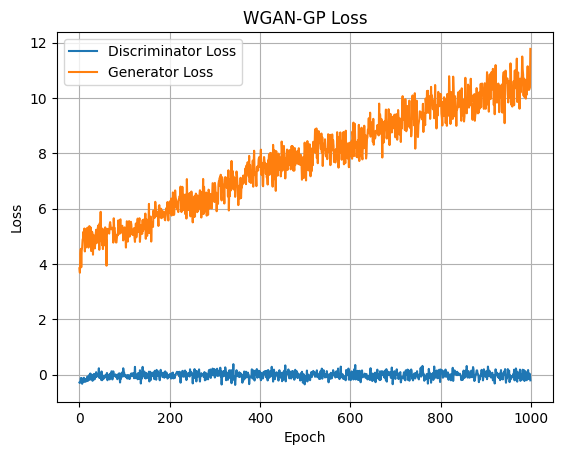

[Cosine Similarity] 평균 코사인 유사도: 0.9195


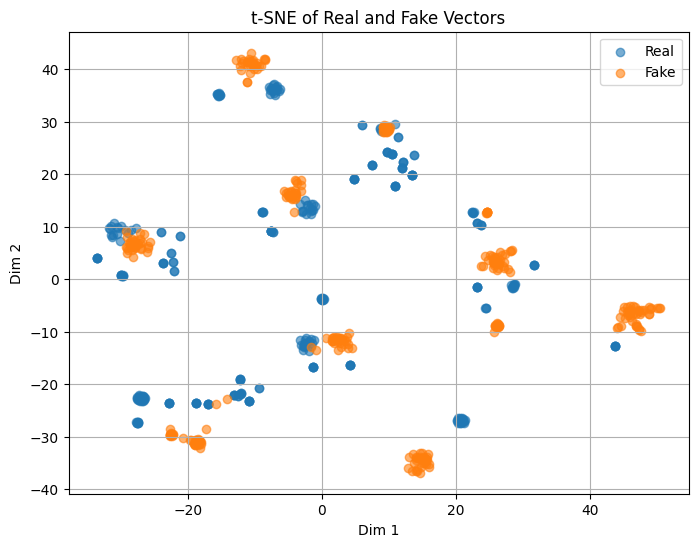

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# -------------------------------
# 설정
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
batch_size = 64
epochs = 1000
lambda_gp = 10
n_critic = 3

# -------------------------------
# 데이터 로드 및 정규화
# -------------------------------
data = np.load("/content/drive/MyDrive/sooin/payload/xss_payload.npy")
data = (data.astype(np.float32) / 127.5) - 1.0
data = torch.tensor(data, dtype=torch.float32)
data += 0.01 * torch.randn_like(data)

dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            Swish(),
            nn.Dropout(0.1),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )
        self.activation = Swish()

    def forward(self, x):
        return self.activation(x + self.block(x))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            Swish(),
            ResidualBlock(512),
            ResidualBlock(512),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            Swish(),
            nn.Linear(256, data.shape[1]),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# -------------------------------
# Critic
# -------------------------------
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data.shape[1], 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# -------------------------------
# Gradient Penalty
# -------------------------------
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand(real_samples.size())
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# -------------------------------
# 모델 초기화
# -------------------------------
G = Generator().to(device)
D = Critic().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# -------------------------------
# 학습
# -------------------------------
g_losses, d_losses = [], []

# --- Generator Loss 개선: Feature Matching 포함 ---
def get_intermediate_features(critic, x):
    with torch.no_grad():
        for i, layer in enumerate(critic.model):
            x = layer(x)
            if i == 3:  # 중간 feature 레이어 지정
                return x.detach()
    return x.detach()

# --- 학습 루프 수정 ---
for epoch in range(epochs):
    for i, (real_batch,) in enumerate(loader):
        real_batch = real_batch.to(device)

        # Critic 학습
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            z *= torch.empty_like(z).uniform_(0.8, 1.2)
            fake_data = G(z).detach()

            real_validity = D(real_batch)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_batch.data, fake_data.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Generator 학습 with Feature Matching
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        z *= torch.empty_like(z).uniform_(0.8, 1.2)
        gen_data = G(z)

        # Feature Matching: Critic 중간 feature 정렬
        with torch.no_grad():
            real_feat = get_intermediate_features(D, real_batch)
        fake_feat = get_intermediate_features(D, gen_data)

        # Generator Loss = WGAN + Feature Matching
        g_adv_loss = -torch.mean(D(gen_data))
        g_feat_loss = nn.MSELoss()(fake_feat, real_feat)
        g_loss = g_adv_loss + 10.0 * g_feat_loss  # λ=10 조정 가능

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} | G_adv: {g_adv_loss.item():.4f} | G_feat: {g_feat_loss.item():.4f}")

# -------------------------------
# 손실 그래프
# -------------------------------
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('WGAN-GP Loss')
plt.grid(True)
plt.show()

# -------------------------------
# 생성 샘플 추출
# -------------------------------
with torch.no_grad():
    real_samples = data[:300].cpu().numpy()
    z = torch.randn(300, latent_dim).to(device)
    z *= torch.empty_like(z).uniform_(0.8, 1.2)
    fake_samples = G(z).cpu().numpy()

X = np.concatenate([real_samples, fake_samples], axis=0)

# -------------------------------
# 코사인 유사도
# -------------------------------
cosine_similarities = [
    1 - cosine(r, f) for r, f in zip(real_samples, fake_samples)
]
print(f"[Cosine Similarity] 평균 코사인 유사도: {np.mean(cosine_similarities):.4f}")

# -------------------------------
# t-SNE 시각화
# -------------------------------
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
embedded = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(embedded[:300, 0], embedded[:300, 1], label="Real", alpha=0.6)
plt.scatter(embedded[300:, 0], embedded[300:, 1], label="Fake", alpha=0.6)
plt.title("t-SNE of Real and Fake Vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = np.concatenate([real_samples, fake_samples], axis=0)
y = np.array([0]*len(real_samples) + [1]*len(fake_samples))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(f"C2ST Accuracy: {accuracy_score(y_test, preds)*100:.2f}%")

C2ST Accuracy: 99.44%


# 5

[100/1000] D: -0.3045 | G_adv: 3.1839 | G_feat: 0.6635
[200/1000] D: -0.2163 | G_adv: 4.4384 | G_feat: 0.8627
[300/1000] D: -0.4230 | G_adv: 5.4910 | G_feat: 2.0849
[400/1000] D: -0.7405 | G_adv: 8.4934 | G_feat: 1.9444
[500/1000] D: -0.3244 | G_adv: 11.5333 | G_feat: 1.7114
[600/1000] D: -0.2332 | G_adv: 13.2760 | G_feat: 1.0515
[700/1000] D: -0.5242 | G_adv: 17.7192 | G_feat: 2.2020
[800/1000] D: -0.1097 | G_adv: 21.6373 | G_feat: 0.6175
[900/1000] D: -0.1769 | G_adv: 23.2920 | G_feat: 0.3620
[1000/1000] D: -0.3646 | G_adv: 19.3390 | G_feat: 1.2796


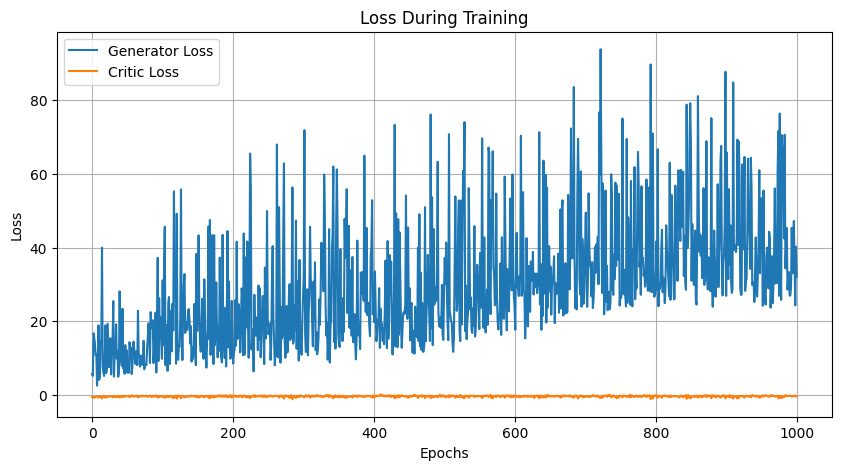

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -------------------------------
# 설정
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
batch_size = 64
epochs = 1000
lambda_gp = 2
n_critic = 3

# -------------------------------
# 데이터 로드 및 정규화
# -------------------------------
data = np.load("/content/drive/MyDrive/sooin/payload/xss_payload.npy")
data = (data.astype(np.float32) / 127.5) - 1.0
data = torch.tensor(data, dtype=torch.float32)
data += 0.01 * torch.randn_like(data)

dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            Swish(),
            nn.Dropout(0.1),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )
        self.activation = Swish()

    def forward(self, x):
        return self.activation(x + self.block(x))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            Swish(),
            ResidualBlock(512),
            ResidualBlock(512),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            Swish(),
            nn.Linear(256, data.shape[1]),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# -------------------------------
# Critic
# -------------------------------
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data.shape[1], 256),
            nn.LayerNorm(256),  # 제거해도 됨
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# -------------------------------
# Gradient Penalty
# -------------------------------
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand(real_samples.size())
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# -------------------------------
# 모델 초기화
# -------------------------------
G = Generator().to(device)
D = Critic().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# -------------------------------
# 학습
# -------------------------------
g_losses, d_losses = [], []

# --- Generator Loss 개선: Feature Matching 포함 ---
# get_intermediate_features 수정
def get_intermediate_features(critic, x):
    for i, layer in enumerate(critic.model):
        x = layer(x)
        if i == 5:  # 더 깊은 feature로
            return x
    return x

# --- 학습 루프 수정 ---
for epoch in range(epochs):
    for i, (real_batch,) in enumerate(loader):
        real_batch = real_batch.to(device)

        # Critic 학습
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            z *= torch.empty_like(z).uniform_(0.6, 1.4)
            fake_data = G(z).detach()

            real_validity = D(real_batch)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_batch.data, fake_data.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Generator 학습 with Feature Matching
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        z *= torch.empty_like(z).uniform_(0.6, 1.4)
        gen_data = G(z)

        # Feature Matching: Critic 중간 feature 정렬
        with torch.no_grad():
            real_feat = get_intermediate_features(D, real_batch)
        fake_feat = get_intermediate_features(D, gen_data)

        # Generator Loss = WGAN + Feature Matching
        g_adv_loss = -torch.mean(D(gen_data))
        g_feat_loss = nn.MSELoss()(fake_feat, real_feat)
        g_loss = g_adv_loss + 10.0 * g_feat_loss  # λ=10 조정 가능

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} | G_adv: {g_adv_loss.item():.4f} | G_feat: {g_feat_loss.item():.4f}")

plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Critic Loss")
plt.title("Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

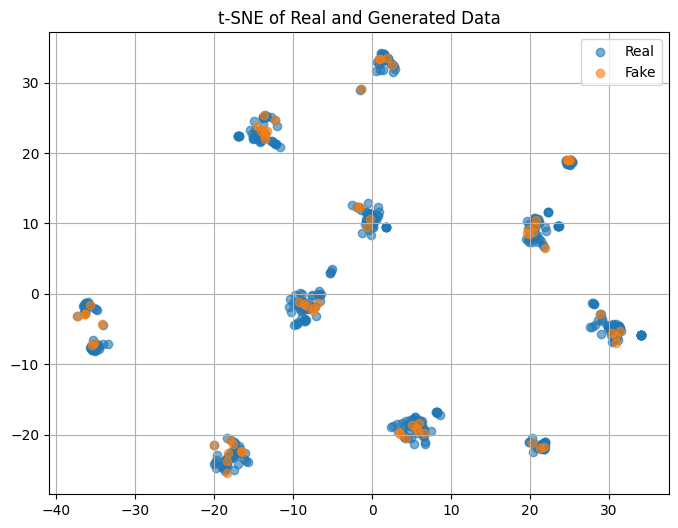

FID Score: 0.4933
Classifier Accuracy: 1.0000
F1 Score: 1.0000


In [ ]:
from sklearn.manifold import TSNE
from scipy.linalg import sqrtm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# -------------------------------
# T-SNE
# -------------------------------
real_samples = next(iter(loader))[0][:500].to(device)
z = torch.randn(500, latent_dim).to(device)
gen_samples = G(z).detach()

combined = torch.cat([real_samples, gen_samples], dim=0).cpu().numpy()
labels = np.array([0]*500 + [1]*500)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded = tsne.fit_transform(combined)

plt.figure(figsize=(8, 6))
plt.scatter(embedded[:500, 0], embedded[:500, 1], label="Real", alpha=0.6)
plt.scatter(embedded[500:, 0], embedded[500:, 1], label="Fake", alpha=0.6)
plt.legend()
plt.title("t-SNE of Real and Generated Data")
plt.grid(True)
plt.show()

# -------------------------------
# FID
# -------------------------------
def calculate_fid(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

real_np = real_samples.cpu().numpy()
fake_np = gen_samples.cpu().numpy()

mu1, sigma1 = np.mean(real_np, axis=0), np.cov(real_np, rowvar=False)
mu2, sigma2 = np.mean(fake_np, axis=0), np.cov(fake_np, rowvar=False)

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID Score: {fid:.4f}")

# -------------------------------
# F1 스코어
# -------------------------------
X = np.concatenate([real_np, fake_np])
y = np.array([1]*len(real_np) + [0]*len(fake_np))

# 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Classifier Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# 6

[100/1000] D: -0.2204 | G_adv: 1.7983 | G_feat: 1.1436
[200/1000] D: -0.1499 | G_adv: 1.5999 | G_feat: 0.2261
[300/1000] D: -0.2838 | G_adv: 1.3158 | G_feat: 0.7155
[400/1000] D: -0.0020 | G_adv: 2.1918 | G_feat: 0.6087
[500/1000] D: -0.2211 | G_adv: 2.6897 | G_feat: 1.6842
[600/1000] D: -0.2724 | G_adv: 4.2548 | G_feat: 1.5639
[700/1000] D: -0.0734 | G_adv: 2.0418 | G_feat: 0.5405
[800/1000] D: -0.2044 | G_adv: 1.6533 | G_feat: 1.1927
[900/1000] D: -0.2431 | G_adv: 3.0044 | G_feat: 0.9122
[1000/1000] D: -0.4479 | G_adv: 2.7703 | G_feat: 2.0570


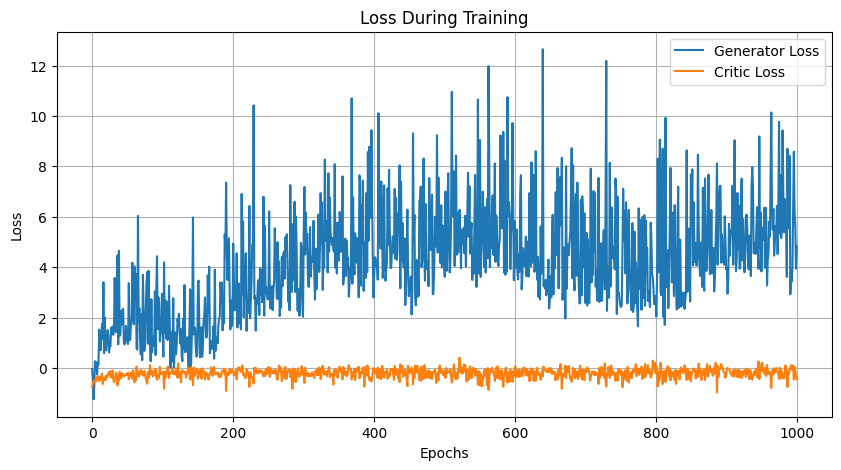

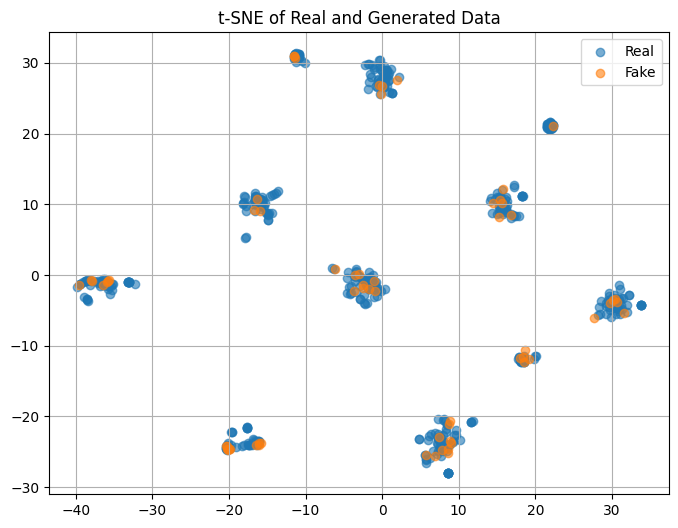

FID Score: 0.8410
Classifier Accuracy: 0.9647
F1 Score: 0.7692


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.linalg import sqrtm

# -------------------------------
# 설정
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
batch_size = 64
epochs = 1000
lambda_gp = 2
n_critic = 3
feature_lambda = 1.0  # Feature Matching 비중 조절

# -------------------------------
# 데이터 로드 및 정규화
# -------------------------------
data = np.load("/content/drive/MyDrive/sooin/payload/xss_payload.npy")
data = (data.astype(np.float32) / 127.5) - 1.0
data = torch.tensor(data, dtype=torch.float32)
data += 0.01 * torch.randn_like(data)

dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# 모델 정의
# -------------------------------
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            Swish(),
            nn.Dropout(0.1),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )
        self.activation = Swish()

    def forward(self, x):
        return self.activation(x + self.block(x))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            Swish(),
            ResidualBlock(512),
            ResidualBlock(512),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            Swish(),
            nn.Linear(256, data.shape[1]),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data.shape[1], 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# -------------------------------
# Gradient Penalty
# -------------------------------
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand(real_samples.size())
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def get_intermediate_features(critic, x):
    for i, layer in enumerate(critic.model):
        x = layer(x)
        if i == 5:
            return x
    return x

# -------------------------------
# 모델 초기화
# -------------------------------
G = Generator().to(device)
D = Critic().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# -------------------------------
# 학습 루프
# -------------------------------
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i, (real_batch,) in enumerate(loader):
        real_batch = real_batch.to(device)

        # Critic 학습
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            z *= torch.empty_like(z).uniform_(0.4, 1.6)
            fake_data = G(z).detach()

            real_validity = D(real_batch)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_batch.data, fake_data.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Generator 학습
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        z *= torch.empty_like(z).uniform_(0.4, 1.6)
        gen_data = G(z)

        with torch.no_grad():
            real_feat = get_intermediate_features(D, real_batch)
        fake_feat = get_intermediate_features(D, gen_data)

        g_adv_loss = -torch.mean(D(gen_data))
        g_feat_loss = nn.MSELoss()(fake_feat, real_feat)
        g_loss = g_adv_loss + feature_lambda * g_feat_loss

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} | G_adv: {g_adv_loss.item():.4f} | G_feat: {g_feat_loss.item():.4f}")

# -------------------------------
# 시각화 및 평가
# -------------------------------

# 1. 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Critic Loss")
plt.title("Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2. T-SNE
real_samples = next(iter(loader))[0][:500].to(device)
z = torch.randn(500, latent_dim).to(device)
gen_samples = G(z).detach()

combined = torch.cat([real_samples, gen_samples], dim=0).cpu().numpy()
labels = np.array([0]*500 + [1]*500)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded = tsne.fit_transform(combined)

plt.figure(figsize=(8, 6))
plt.scatter(embedded[:500, 0], embedded[:500, 1], label="Real", alpha=0.6)
plt.scatter(embedded[500:, 0], embedded[500:, 1], label="Fake", alpha=0.6)
plt.legend()
plt.title("t-SNE of Real and Generated Data")
plt.grid(True)
plt.show()

# 3. FID
def calculate_fid(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

real_np = real_samples.cpu().numpy()
fake_np = gen_samples.cpu().numpy()
mu1, sigma1 = np.mean(real_np, axis=0), np.cov(real_np, rowvar=False)
mu2, sigma2 = np.mean(fake_np, axis=0), np.cov(fake_np, rowvar=False)
fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID Score: {fid:.4f}")

# 4. F1 Score & Accuracy with PCA
X = np.concatenate([real_np, fake_np])
y = np.array([1]*len(real_np) + [0]*len(fake_np))

X_pca = PCA(n_components=10).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Classifier Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# PacGAN + WGAN-GP

[100/1000] D: -0.0932 | G_adv: -7.3820 | G_feat: 0.0651
[200/1000] D: 0.0955 | G_adv: -9.5446 | G_feat: 0.0998
[300/1000] D: 0.1967 | G_adv: -14.5025 | G_feat: 0.2438
[400/1000] D: 0.0797 | G_adv: -19.8417 | G_feat: 0.3875
[500/1000] D: -0.0652 | G_adv: -21.6055 | G_feat: 1.1063
[600/1000] D: -0.1850 | G_adv: -25.6349 | G_feat: 0.9657
[700/1000] D: -0.0480 | G_adv: -33.4811 | G_feat: 0.8980
[800/1000] D: -0.0391 | G_adv: -34.1523 | G_feat: 1.0311
[900/1000] D: 0.1794 | G_adv: -39.5254 | G_feat: 0.9069
[1000/1000] D: 0.0482 | G_adv: -37.1474 | G_feat: 1.2649


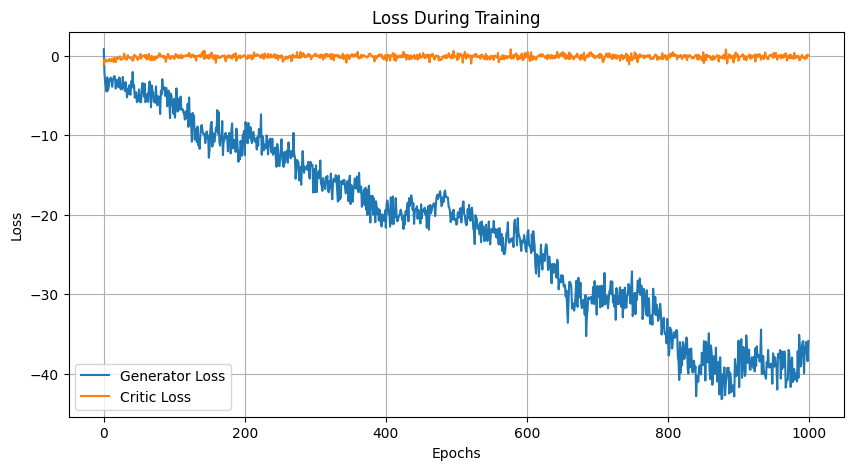

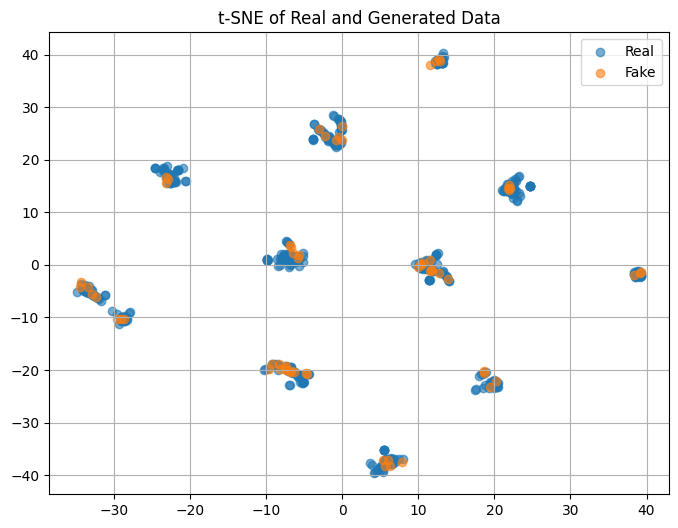

FID Score: 0.5293
Classifier Accuracy: 0.9529
F1 Score: 0.7143


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.linalg import sqrtm

# -------------------------------
# 설정
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
batch_size = 64
epochs = 1000
lambda_gp = 2
n_critic = 3
feature_lambda = 1.0
pac_dim = 2  # PacGAN 핵심!

# -------------------------------
# 데이터 로드 및 정규화
# -------------------------------
data = np.load("/content/drive/MyDrive/sooin/payload/xss_payload.npy")
data = (data.astype(np.float32) / 127.5) - 1.0
data = torch.tensor(data, dtype=torch.float32)
data += 0.01 * torch.randn_like(data)
dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# 모델 정의
# -------------------------------
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            Swish(),
            nn.Dropout(0.1),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )
        self.activation = Swish()

    def forward(self, x):
        return self.activation(x + self.block(x))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            Swish(),
            ResidualBlock(512),
            ResidualBlock(512),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            Swish(),
            nn.Linear(256, data.shape[1]),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class PacCritic(nn.Module):
    def __init__(self):
        super().__init__()
        input_dim = data.shape[1] * pac_dim  # PacGAN: 입력이 pac_dim개씩 결합됨
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

# -------------------------------
# Gradient Penalty
# -------------------------------
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand_as(real_samples)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def get_intermediate_features(critic, x):
    for i, layer in enumerate(critic.model):
        x = layer(x)
        if i == 4:
            return x
    return x

# -------------------------------
# 모델 초기화
# -------------------------------
G = Generator().to(device)
D = PacCritic().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# -------------------------------
# 학습 루프
# -------------------------------
g_losses, d_losses = [], []

for epoch in range(epochs):
    for real_batch, in loader:
        real_batch = real_batch.to(device)

        truncate_len = (real_batch.size(0) // pac_dim) * pac_dim
        real_batch = real_batch[:truncate_len]

        # Critic 학습
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            z *= torch.empty_like(z).uniform_(0.4, 1.6)
            fake_data = G(z).detach()

            # PacGAN: pac_dim 개씩 결합
            real_grouped = real_batch.view(-1, pac_dim * data.shape[1])
            fake_grouped = fake_data.view(-1, pac_dim * data.shape[1])

            real_validity = D(real_grouped)
            fake_validity = D(fake_grouped)
            gp = compute_gradient_penalty(D, real_grouped, fake_grouped)

            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Generator 학습
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        z *= torch.empty_like(z).uniform_(0.4, 1.6)
        gen_data = G(z)

        fake_grouped = gen_data.view(-1, pac_dim * data.shape[1])
        real_grouped = real_batch.view(-1, pac_dim * data.shape[1])

        with torch.no_grad():
            real_feat = get_intermediate_features(D, real_grouped)
        fake_feat = get_intermediate_features(D, fake_grouped)

        g_adv_loss = -torch.mean(D(fake_grouped))
        g_feat_loss = nn.MSELoss()(fake_feat, real_feat)
        g_loss = g_adv_loss + feature_lambda * g_feat_loss

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} | G_adv: {g_adv_loss.item():.4f} | G_feat: {g_feat_loss.item():.4f}")

# -------------------------------
# 평가
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Critic Loss")
plt.title("Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# t-SNE
real_samples = next(iter(loader))[0][:500].to(device)
z = torch.randn(500, latent_dim).to(device)
gen_samples = G(z).detach()

combined = torch.cat([real_samples, gen_samples], dim=0).cpu().numpy()
labels = np.array([0]*500 + [1]*500)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded = tsne.fit_transform(combined)

plt.figure(figsize=(8, 6))
plt.scatter(embedded[:500, 0], embedded[:500, 1], label="Real", alpha=0.6)
plt.scatter(embedded[500:, 0], embedded[500:, 1], label="Fake", alpha=0.6)
plt.legend()
plt.title("t-SNE of Real and Generated Data")
plt.grid(True)
plt.show()

# FID
def calculate_fid(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

real_np = real_samples.cpu().numpy()
fake_np = gen_samples.cpu().numpy()
mu1, sigma1 = np.mean(real_np, axis=0), np.cov(real_np, rowvar=False)
mu2, sigma2 = np.mean(fake_np, axis=0), np.cov(fake_np, rowvar=False)
fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID Score: {fid:.4f}")

# F1 Score & Accuracy
X = np.concatenate([real_np, fake_np])
y = np.array([1]*len(real_np) + [0]*len(fake_np))
X_pca = PCA(n_components=10).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Classifier Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

In [2]:
# -------------------------------
# 생성 페이로드 저장
# -------------------------------
def save_generated_payloads(generator, latent_dim=128, num_samples=1000, device='cpu'):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_payloads = generator(z)
        np.save("/content/drive/MyDrive/sooin/payload/generated_xss_payloads.npy", generated_payloads.cpu().numpy())
        print(f"✅ {num_samples}개 생성 페이로드를 'generated_xss_payloads.npy'로 저장 완료")